<a href="https://colab.research.google.com/github/Saaiheswar/NeuralStyle_TransferPreserve/blob/main/Final_nueral_preserve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy==1.1.0

(1, 256, 256, 3)
(1, 256, 256, 3)
content array shape= (1, 256, 256, 3) 

58900480/58889256 [==============================] - 1s 0us/step
Tensor("strided_slice_2:0", shape=(256, 256, 64), dtype=float32)
Tensor("Reshape:0", shape=(64, 65536), dtype=float32)
Tensor("transpose_1:0", shape=(65536, 64), dtype=float32)
Tensor("strided_slice_3:0", shape=(256, 256, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(64, 65536), dtype=float32)
Tensor("transpose_4:0", shape=(65536, 64), dtype=float32)
Tensor("strided_slice_6:0", shape=(128, 128, 128), dtype=float32)
Tensor("Reshape_2:0", shape=(128, 16384), dtype=float32)
Tensor("transpose_7:0", shape=(16384, 128), dtype=float32)
Tensor("strided_slice_7:0", shape=(128, 128, 128), dtype=float32)
Tensor("Reshape_3:0", shape=(128, 16384), dtype=float32)
Tensor("transpose_10:0", shape=(16384, 128), dtype=float32)
Tensor("strided_slice_10:0", shape=(64, 64, 256), dtype=float32)
Tensor("Reshape_4:0", shape=(256, 4096), dtype=float32)
Tensor("transpose_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Start of iteration 0
23421797000000.0
Iteration 0 completed in 34s
Start of iteration 1
12846466000000.0
Iteration 1 completed in 1s
Start of iteration 2
8469744000000.0
Iteration 2 completed in 1s
Start of iteration 3
7266175500000.0
Iteration 3 completed in 1s
Start of iteration 4
6839567000000.0
Iteration 4 completed in 1s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.


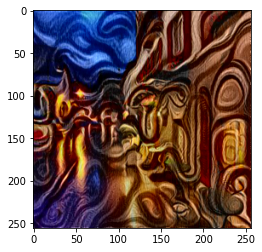

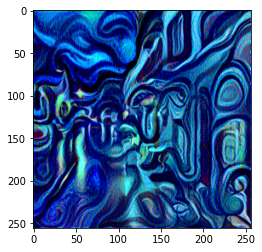

In [ ]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import tensorflow as tf
from scipy.misc import fromimage, toimage,imread,imresize
########################################################
###### DATA AQUISITION###############
tf.compat.v1.disable_eager_execution()
content_image=Image.open('/content/sample_data/content.jpg')
content_image=content_image.resize((256,256))
#content_image=content_image.resize((512,512))
style_image= Image.open('/content/sample_data/blue_swirls.jpg')
style_image=style_image.resize((256,256))
#style_image=style_image.resize((512,512))
style_image.size
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0) #image dimension expansions
#content_array=np.array(content_array).copy()

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
##########################################################
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)
content_array[:, :, :, 0] -= 183.939
content_array[:, :, :, 1] -= 186.779
content_array[:, :, :, 2] -= 183.68
content_array=content_array[:, :, :, ::-1]
style_array[:, :, :, 0] -= 183.939
style_array[:, :, :, 1] -= 186.779
style_array[:, :, :, 2] -= 183.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

print('content array shape=',content_array.shape,'\n')
height=256
width=256
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
#print('Input_Tensor:',input_tensor)
####FUNCTIONS
def deprocess_image(x):
    x = x.reshape((height, width, 3))
    x[:, :, 0] += 183.939
    x[:, :, 1] += 186.779
    x[:, :, 2] += 183.68

    # BGR to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def original_colour_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated
############
#######MODEL CREATION
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
content_weight = 5.5
style_weight = 5
total_variation_weight = 1.5
#content_weight = 2.5
#style_weight = 7.0
#total_variation_weight = 1.5
layers=dict([(layer.name, layer.output) for layer in model.layers])
loss=backend.variable(0.)
###############################################################################
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_features)
def gram_matrix(x):
    print(x)
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    print(features)# 64*65536
    temp = backend.transpose(features)
    print(temp)# 65536*64
    gram=backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square((4*S - 3*C))) / (4. * (channels ** 2) * (size ** 2))
    return st
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3','block2_conv2']
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    return backend.sum(backend.pow(a**1.25 +  b**1.15, 1.25))
loss = loss+total_variation_weight * total_variation_loss(combination_image)
grads = backend.gradients(loss, combination_image)
outputs=[loss]
###################################################################
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator=Evaluator()
x=np.random.uniform(0,255,(1,height,width,3))-128.0
content_img_path = '/content/sample_data/content.jpg' 
content_img = imread(content_img_path, mode="YCbCr")
content_img = imresize(content_img, (height, width))
#####################################################################################
iterations = 5
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print
img = deprocess_image(x.copy())
img = original_colour_transform(content_img,img)
Image.fromarray(img)
imgplot = plt.imshow(Image.fromarray(img))
plt.show()
z = x.copy();
#z = z.reshape((content_array_height,content_array_width,3))
x = x.reshape((height, width, 3))
x[:, :, 0] += 183.939
x[:, :, 1] += 186.779
x[:, :, 2] += 183.68
x = x[:,:,::-1]
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
imgplot = plt.imshow(Image.fromarray(x))
plt.show()



# New Section

(1, 256, 256, 3)
(1, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Start of iteration 0
2817741800000.0
Iteration 0 completed in 2s
Start of iteration 1
1548827800000.0
Iteration 1 completed in 1s
Start of iteration 2
1045741100000.0
Iteration 2 completed in 1s
Start of iteration 3
808713850000.0
Iteration 3 completed in 2s
Start of iteration 4
717336200000.0
Iteration 4 completed in 2s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.


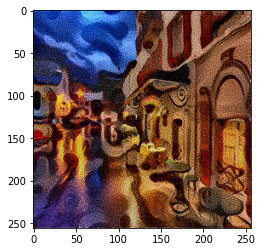

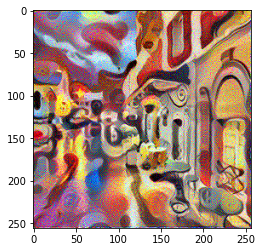

In [ ]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import tensorflow as tf
########################################################
###### DATA AQUISITION###############
tf.compat.v1.disable_eager_execution()
content_image=Image.open('/content/sample_data/content.jpg')
content_image=content_image.resize((256,256))
style_image= Image.open('/content/sample_data/candy-style.jpg')
style_image=style_image.resize((256,256))
style_image.size
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0) #image dimension expansions
#content_array=np.array(content_array).copy()

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
##########################################################
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)
content_array[:, :, :, 0] -= 183.939
content_array[:, :, :, 1] -= 186.779
content_array[:, :, :, 2] -= 183.68
content_array=content_array[:, :, :, ::-1]
style_array[:, :, :, 0] -= 183.939
style_array[:, :, :, 1] -= 186.779
style_array[:, :, :, 2] -= 183.68

style_array=style_array[:, :, :, ::-1]
style_array.shape
height=256
width=256
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
####FUNCTIONS
def deprocess_image(x):
    x = x.reshape((height, width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def original_colour_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated
############
#######MODEL CREATION
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
content_weight = 1.5
style_weight = 9.0
total_variation_weight = 1.5
layers=dict([(layer.name, layer.output) for layer in model.layers])
loss=backend.variable(0.)
###############################################################################
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_features)
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels**2 ) * (size**1.9))
    return st
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3','block2_conv2']
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]*x[:0,:height-1,:width-1,:]-x[:,1:,:width-1,:])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    return backend.sum(backend.pow(a**1.45+  b**1.35, 1.25))
loss = loss+total_variation_weight * total_variation_loss(combination_image)
grads = backend.gradients(loss, combination_image)
outputs=[loss]
###################################################################
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator=Evaluator()
x=np.random.uniform(0,255,(1,height,width,3))-128.0
content_img_path = '/content/sample_data/content.jpg' 
content_img = imread(content_img_path, mode="YCbCr")
content_img = imresize(content_img, (height, width))
#####################################################################################
iterations = 5
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print
img = deprocess_image(x.copy())
img = original_colour_transform(content_img,img)
Image.fromarray(img)
imgplot = plt.imshow(Image.fromarray(img))
plt.show()
x = x.reshape((height, width, 3))
y = x
x = x[:, :, ::-1]
x[:, :, 0] += 183.939
x[:, :, 1] += 186.779
x[:, :, 2] += 183.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
imgplot = plt.imshow(Image.fromarray(x))
plt.show()



Start of iteration 0
1901782900000.0
Iteration 0 completed in 1s
Start of iteration 1
1212409200000.0
Iteration 1 completed in 1s
Start of iteration 2
870880640000.0
Iteration 2 completed in 1s
Start of iteration 3
765144500000.0
Iteration 3 completed in 1s
Start of iteration 4
708805260000.0
Iteration 4 completed in 2s


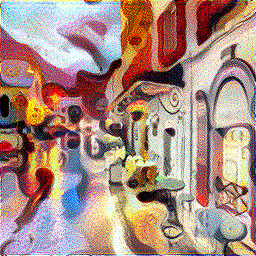

In [ ]:
f1_outputs = backend.function([content_image], outputs)
#y=np.random.uniform(0,255,(1,height,width,3))-128.0
#####################################################################################
iterations = 5
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    y, min_val, info = fmin_l_bfgs_b(evaluator.loss, y.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print
y = y.reshape((height, width, 3))
y = y[:, :, ::-1]
y[:, :, 0] += 183.939
y[:, :, 1] += 186.779
y[:, :, 2] += 183.68
y = np.clip(y, 0, 255).astype('uint8')
Image.fromarray(y)

(1, 256, 256, 3)
(1, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Start of iteration 0
3818788700000.0
Iteration 0 completed in 2s
Start of iteration 1
2310029700000.0
Iteration 1 completed in 1s
Start of iteration 2
1869273100000.0
Iteration 2 completed in 2s
Start of iteration 3
1681915100000.0
Iteration 3 completed in 2s
Start of iteration 4
1592471500000.0
Iteration 4 completed in 2s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.


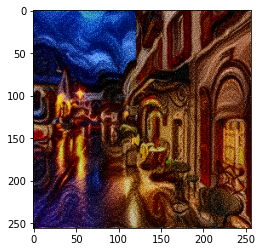

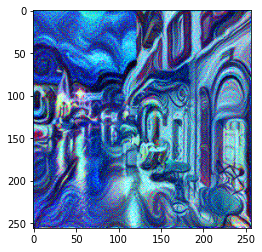

In [ ]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import tensorflow as tf
########################################################
###### DATA AQUISITION###############
tf.compat.v1.disable_eager_execution()
content_image=Image.open('/content/sample_data/content.jpg')
content_image=content_image.resize((256,256))
style_image= Image.open('/content/sample_data/blue_swirls.jpg')
style_image=style_image.resize((256,256))
style_image.size
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0) #image dimension expansions
#content_array=np.array(content_array).copy()

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
##########################################################
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)
content_array[:, :, :, 0] -= 183.939
content_array[:, :, :, 1] -= 186.779
content_array[:, :, :, 2] -= 183.68
content_array=content_array[:, :, :, ::-1]
style_array[:, :, :, 0] -= 183.939
style_array[:, :, :, 1] -= 186.779
style_array[:, :, :, 2] -= 183.68

style_array=style_array[:, :, :, ::-1]
style_array.shape
height=256
width=256
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
####FUNCTIONS
def deprocess_image(x):
    x = x.reshape((height, width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def original_colour_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated
############
#######MODEL CREATION
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
content_weight = 2.5
style_weight = 7.0
total_variation_weight = 1.5
layers=dict([(layer.name, layer.output) for layer in model.layers])
loss=backend.variable(0.)
###############################################################################
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_features)
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3','block2_conv2']
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]*x[:0,:height-1,:width-1,:]-x[:,1:,:width-1,:])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])+backend.square(x[:,:height-1,:width-1,:]*x[:0,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    return backend.sum(backend.pow(a**1.25+  b**1.55, 1.25))
loss = loss+total_variation_weight * total_variation_loss(combination_image)
grads = backend.gradients(loss, combination_image)
outputs=[loss]
###################################################################
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator=Evaluator()
x=np.random.uniform(0,255,(1,height,width,3))-128.0
content_img_path = '/content/sample_data/content.jpg' 
content_img = imread(content_img_path, mode="YCbCr")
content_img = imresize(content_img, (height, width))
#####################################################################################
iterations = 5
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print
img = deprocess_image(x.copy())
img = original_colour_transform(content_img,img)
Image.fromarray(img)
imgplot = plt.imshow(Image.fromarray(img))
plt.show()
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 183.939
x[:, :, 1] += 186.779
x[:, :, 2] += 183.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
imgplot = plt.imshow(Image.fromarray(x))
plt.show()



(1, 256, 256, 3)
(1, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Start of iteration 0
4359164300000.0
Iteration 0 completed in 2s
Start of iteration 1
1774919000000.0
Iteration 1 completed in 1s
Start of iteration 2
919019300000.0
Iteration 2 completed in 1s
Start of iteration 3
697107150000.0
Iteration 3 completed in 2s
Start of iteration 4
635332700000.0
Iteration 4 completed in 2s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning:     `fromimage` is deprecated!
    `fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
    Use ``np.asarray(im)`` instead.


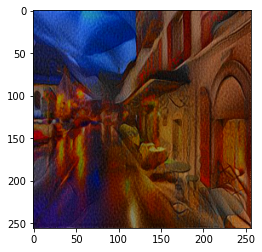

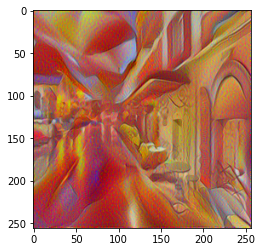

In [ ]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import tensorflow as tf
########################################################
###### DATA AQUISITION###############
tf.compat.v1.disable_eager_execution()
content_image=Image.open('/content/sample_data/content.jpg')
content_image=content_image.resize((256,256))
style_image= Image.open('/content/sample_data/red-canna.jpg')
style_image=style_image.resize((256,256))
style_image.size
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0) #image dimension expansions
#content_array=np.array(content_array).copy()

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
##########################################################
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)
content_array[:, :, :, 0] -= 183.939
content_array[:, :, :, 1] -= 186.779
content_array[:, :, :, 2] -= 183.68
content_array=content_array[:, :, :, ::-1]
style_array[:, :, :, 0] -= 183.939
style_array[:, :, :, 1] -= 186.779
style_array[:, :, :, 2] -= 183.68

style_array=style_array[:, :, :, ::-1]
style_array.shape
height=256
width=256
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
####FUNCTIONS
def deprocess_image(x):
    x = x.reshape((height, width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def original_colour_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated
############
#######MODEL CREATION
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
content_weight = 1.5
style_weight = 9.0
total_variation_weight = 1.5
layers=dict([(layer.name, layer.output) for layer in model.layers])
loss=backend.variable(0.)
###############################################################################
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_features)
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(2*S - 3*C)) / (4. * (channels ** 2) * (size ** 2))
    return st
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3','block2_conv2']
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])+backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    return backend.sum(backend.pow(a**1.15+  b**1.15, 1.25))
loss = loss+total_variation_weight * total_variation_loss(combination_image)
grads = backend.gradients(loss, combination_image)
outputs=[loss]
###################################################################
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator=Evaluator()
x=np.random.uniform(0,255,(1,height,width,3))-128.0
content_img_path = '/content/sample_data/content.jpg' 
content_img = imread(content_img_path, mode="YCbCr")
content_img = imresize(content_img, (height, width))
#####################################################################################
iterations = 5
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print
img = deprocess_image(x.copy())
img = original_colour_transform(content_img,img)
Image.fromarray(img)
imgplot = plt.imshow(Image.fromarray(img))
plt.show()
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 183.939
x[:, :, 1] += 186.779
x[:, :, 2] += 183.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
imgplot = plt.imshow(Image.fromarray(x))
plt.show()



# New Section